IMPORT Libarrays 

In [27]:
import pandas as pd
import numpy as np

In [3]:
import os

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [68]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [4]:
from bs4 import BeautifulSoup
import requests

Import dataset from kaggle or local file

In [5]:
directory = '1_movies_per_genre'

files = os.listdir(directory)

for file in files:
    print(file)

Action.csv
Adventure.csv
Animation.csv
Biography.csv
Comedy.csv
Crime.csv
Drama.csv
Fantasy.csv
History.csv
Horror.csv
Music.csv
Mystery.csv
Romance.csv
Sci-Fi.csv
Sport.csv
Thriller.csv
War.csv


Marge all dataset file into one single dataset

In [6]:

directory = '1_movies_per_genre'
main_dataset = pd.DataFrame()

files = os.listdir(directory)

for file in files:
    file_path = os.path.join(directory, file)
    dataset = pd.read_csv(file_path)
    main_dataset = pd.concat([main_dataset, dataset], ignore_index=True)

print(main_dataset)

                                                   name  year movie_rated  \
0                                       The Dark Knight  2008       PG-13   
1                                             Inception  2010       PG-13   
2                                            The Matrix  1999           R   
3     The Lord of the Rings: The Fellowship of the Ring  2001       PG-13   
4                                 The Dark Knight Rises  2012       PG-13   
...                                                 ...   ...         ...   
1695                                           Catch-22  1970           R   
1696                                     The Great Raid  2005           R   
1697                                Saints and Soldiers  2003       PG-13   
1698                                          Stop-Loss  2008           R   
1699                                          The Alamo  2004       PG-13   

     run_length                       genres            release_date  ratin

In [7]:
main_dataset.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews,review_url
0,The Dark Knight,2008,PG-13,2h 32min,Action; Crime; Drama;,18 July 2008 (USA),9.0,2224522,6836,https://www.imdb.com/title/tt0468569/reviews/_...
1,Inception,2010,PG-13,2h 28min,Action; Adventure; Sci-Fi;,16 July 2010 (USA),8.8,1981675,3820,https://www.imdb.com/title/tt1375666/reviews/_...
2,The Matrix,1999,R,2h 16min,Action; Sci-Fi;,31 March 1999 (USA),8.7,1619761,4281,https://www.imdb.com/title/tt0133093/reviews/_...
3,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,2h 58min,Action; Adventure; Drama;,19 December 2001 (USA),8.8,1609165,5365,https://www.imdb.com/title/tt0120737/reviews/_...
4,The Dark Knight Rises,2012,PG-13,2h 44min,Action; Adventure;,20 July 2012 (USA),8.4,1470329,2979,https://www.imdb.com/title/tt1345836/reviews/_...


In [8]:
df = main_dataset.copy()


In [9]:
df.shape

(1700, 10)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          1700 non-null   object 
 1   year          1700 non-null   int64  
 2   movie_rated   1700 non-null   object 
 3   run_length    1700 non-null   object 
 4   genres        1700 non-null   object 
 5   release_date  1700 non-null   object 
 6   rating        1700 non-null   float64
 7   num_raters    1700 non-null   int64  
 8   num_reviews   1700 non-null   int64  
 9   review_url    1700 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 132.9+ KB


In [11]:
df.isnull().sum()

name            0
year            0
movie_rated     0
run_length      0
genres          0
release_date    0
rating          0
num_raters      0
num_reviews     0
review_url      0
dtype: int64

In [12]:
df.columns

Index(['name', 'year', 'movie_rated', 'run_length', 'genres', 'release_date',
       'rating', 'num_raters', 'num_reviews', 'review_url'],
      dtype='object')

In [13]:
df.describe()

,year,rating,num_raters,num_reviews
count,1700.000000,1700.000000,1.700000e+03,1700.000000
mean,2002.798235,7.457706,4.134152e+05,1003.601176
std,14.359010,0.736682,3.277902e+05,1045.584805
min,1915.000000,3.500000,1.929000e+04,102.000000
25%,1999.000000,7.000000,1.812258e+05,393.750000
50%,2006.000000,7.600000,3.445890e+05,719.500000
75%,2012.000000,8.000000,5.722170e+05,1256.500000
max,2020.000000,9.300000,2.258845e+06,10279.000000


Fetch data using reviews_urls and store it into reviews column

In [16]:
import time

def get_review(x):
    reviews = []
    try:
        response = requests.get(x, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        comments = soup.find_all('div', class_='text show-more__control')

        for comment in comments:
            reviews.append(comment.text.strip())

        return ' '.join(reviews)
    except requests.exceptions.RequestException as e:
        print(f"Request error at {x}: {e}")
        return "Error fetching review"

# Check for existing reviews and update only if the review is not present
if 'review' not in df.columns:
    df['review'] = None

for index, row in df.iterrows():
    if pd.isnull(row['review']) or row['review'] == '':
        print(f"Fetching review for URL: {row['review_url']}")
        df.at[index, 'review'] = get_review(row['review_url'])
    else:
        print(f"Review already present for URL: {row['review_url']}")

# Save the updated DataFrame to a new dataset or file
df.to_csv('updated_reviews.csv', index=False)

print(df)

Fetching review for URL: https://www.imdb.com/title/tt0468569/reviews/_ajax?ref_=undefined&paginationKey=
Fetching review for URL: https://www.imdb.com/title/tt1375666/reviews/_ajax?ref_=undefined&paginationKey=
Fetching review for URL: https://www.imdb.com/title/tt0133093/reviews/_ajax?ref_=undefined&paginationKey=
Fetching review for URL: https://www.imdb.com/title/tt0120737/reviews/_ajax?ref_=undefined&paginationKey=
Fetching review for URL: https://www.imdb.com/title/tt1345836/reviews/_ajax?ref_=undefined&paginationKey=
Fetching review for URL: https://www.imdb.com/title/tt0172495/reviews/_ajax?ref_=undefined&paginationKey=
Fetching review for URL: https://www.imdb.com/title/tt0372784/reviews/_ajax?ref_=undefined&paginationKey=
Fetching review for URL: https://www.imdb.com/title/tt0848228/reviews/_ajax?ref_=undefined&paginationKey=
Fetching review for URL: https://www.imdb.com/title/tt0076759/reviews/_ajax?ref_=undefined&paginationKey=
Fetching review for URL: https://www.imdb.com/

In [18]:
new_df = pd.read_csv("updated_reviews.csv")

In [19]:
new_df.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews,review_url,review
0,The Dark Knight,2008,PG-13,2h 32min,Action; Crime; Drama;,18 July 2008 (USA),9.0,2224522,6836,https://www.imdb.com/title/tt0468569/reviews/_...,Best movie ever. Heath ledger's work is phenom...
1,Inception,2010,PG-13,2h 28min,Action; Adventure; Sci-Fi;,16 July 2010 (USA),8.8,1981675,3820,https://www.imdb.com/title/tt1375666/reviews/_...,"My 3rd time watching this movie! Yet, it still..."
2,The Matrix,1999,R,2h 16min,Action; Sci-Fi;,31 March 1999 (USA),8.7,1619761,4281,https://www.imdb.com/title/tt0133093/reviews/_...,I have an interesting history and relationship...
3,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,2h 58min,Action; Adventure; Drama;,19 December 2001 (USA),8.8,1609165,5365,https://www.imdb.com/title/tt0120737/reviews/_...,Simply incredible. Never before have I seen a ...
4,The Dark Knight Rises,2012,PG-13,2h 44min,Action; Adventure;,20 July 2012 (USA),8.4,1470329,2979,https://www.imdb.com/title/tt1345836/reviews/_...,"After eight years in seclusion, Batman resurfa..."


In [17]:
df.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews,review_url,review
0,The Dark Knight,2008,PG-13,2h 32min,Action; Crime; Drama;,18 July 2008 (USA),9.0,2224522,6836,https://www.imdb.com/title/tt0468569/reviews/_...,Best movie ever. Heath ledger's work is phenom...
1,Inception,2010,PG-13,2h 28min,Action; Adventure; Sci-Fi;,16 July 2010 (USA),8.8,1981675,3820,https://www.imdb.com/title/tt1375666/reviews/_...,"My 3rd time watching this movie! Yet, it still..."
2,The Matrix,1999,R,2h 16min,Action; Sci-Fi;,31 March 1999 (USA),8.7,1619761,4281,https://www.imdb.com/title/tt0133093/reviews/_...,I have an interesting history and relationship...
3,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,2h 58min,Action; Adventure; Drama;,19 December 2001 (USA),8.8,1609165,5365,https://www.imdb.com/title/tt0120737/reviews/_...,Simply incredible. Never before have I seen a ...
4,The Dark Knight Rises,2012,PG-13,2h 44min,Action; Adventure;,20 July 2012 (USA),8.4,1470329,2979,https://www.imdb.com/title/tt1345836/reviews/_...,"After eight years in seclusion, Batman resurfa..."


In [20]:
df = df.drop("review_url",axis=1)

In [21]:
df.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews,review
0,The Dark Knight,2008,PG-13,2h 32min,Action; Crime; Drama;,18 July 2008 (USA),9.0,2224522,6836,Best movie ever. Heath ledger's work is phenom...
1,Inception,2010,PG-13,2h 28min,Action; Adventure; Sci-Fi;,16 July 2010 (USA),8.8,1981675,3820,"My 3rd time watching this movie! Yet, it still..."
2,The Matrix,1999,R,2h 16min,Action; Sci-Fi;,31 March 1999 (USA),8.7,1619761,4281,I have an interesting history and relationship...
3,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,2h 58min,Action; Adventure; Drama;,19 December 2001 (USA),8.8,1609165,5365,Simply incredible. Never before have I seen a ...
4,The Dark Knight Rises,2012,PG-13,2h 44min,Action; Adventure;,20 July 2012 (USA),8.4,1470329,2979,"After eight years in seclusion, Batman resurfa..."


In [22]:
df['name'].value_counts()

name
The Lion King               4
The Dark Knight             3
The Grand Budapest Hotel    3
Shrek                       3
Inside Out                  3
                           ..
The New World               1
The Death of Stalin         1
Centurion                   1
The Duchess                 1
The Alamo                   1
Name: count, Length: 1145, dtype: int64

In [24]:
df.duplicated().sum()

307

In [25]:
df.drop_duplicates(inplace=True)

In [26]:
df.duplicated().sum()

0

convert movie length hour or min into numerical formate 

In [28]:
df['run_length'] = df['run_length'].str.replace('h','*1').str.replace(' ','+').str.replace('min','/60').apply(eval)

In [30]:
df['run_length'][0]

2.533333333333333

In [31]:
df['movie_rated'].value_counts()

movie_rated
R            604
PG-13        485
PG           196
G             44
Not Rated     36
Approved       9
Passed         9
TV-MA          3
GP             2
NC-17          1
Null           1
M/PG           1
TV-14          1
TV-PG          1
Name: count, dtype: int64

some movies are not rated. We will replace with NaN and then mode

In [45]:
df['movie_rated'].replace(['Not Rated', 'Null'], np.nan, inplace=True)

# Fill missing values with the mode
df['movie_rated'].fillna(df['movie_rated'].mode()[0], inplace=True)

print(df)

                                                   name  year movie_rated  \
0                                       The Dark Knight  2008       PG-13   
1                                             Inception  2010       PG-13   
2                                            The Matrix  1999           R   
3     The Lord of the Rings: The Fellowship of the Ring  2001       PG-13   
4                                 The Dark Knight Rises  2012       PG-13   
...                                                 ...   ...         ...   
1695                                           Catch-22  1970           R   
1696                                     The Great Raid  2005           R   
1697                                Saints and Soldiers  2003       PG-13   
1698                                          Stop-Loss  2008           R   
1699                                          The Alamo  2004       PG-13   

      run_length                       genres            release_date  rati

In [51]:
df['movie_rated'].value_counts()

movie_rated
R           641
PG-13       485
PG          196
G            44
Approved      9
Passed        9
TV-MA         3
GP            2
NC-17         1
M/PG          1
TV-14         1
TV-PG         1
Name: count, dtype: int64

Visulize data

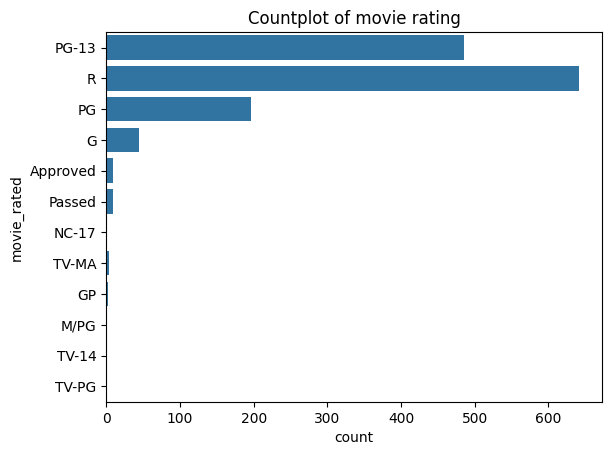

In [49]:
sns.countplot(y = df['movie_rated'])
plt.title('Countplot of movie rating')
plt.show()

In [52]:
def movie_rating(x):
    other = ['Approved', 'Passed', 'NC-17', 'TV-MA','GP', 'M/PG', 'TV-14', 'TV-PG']

    if x.strip() in other:
        return 'Other'
    else:
        return x

df['movie_rated'] = df['movie_rated'].apply(movie_rating)

In [56]:
df['movie_rated'].value_counts()

movie_rated
R        641
PG-13    485
PG       196
G         44
Other     27
Name: count, dtype: int64

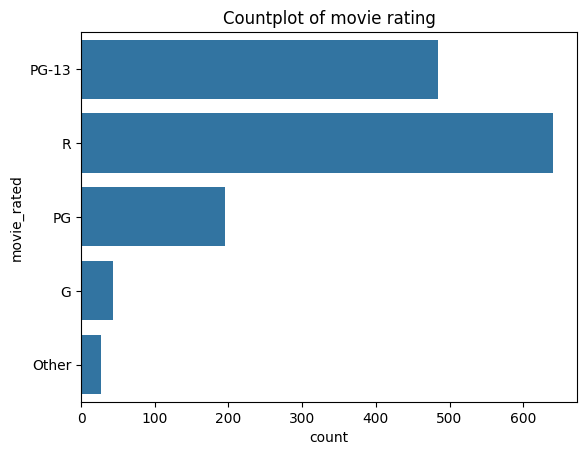

In [58]:
sns.countplot(y = df['movie_rated'])
plt.title('Countplot of movie rating')
plt.show()

In [60]:
#seperating genres
df['genres'] = df['genres'].apply(lambda x: x.split('; ')[:-1])

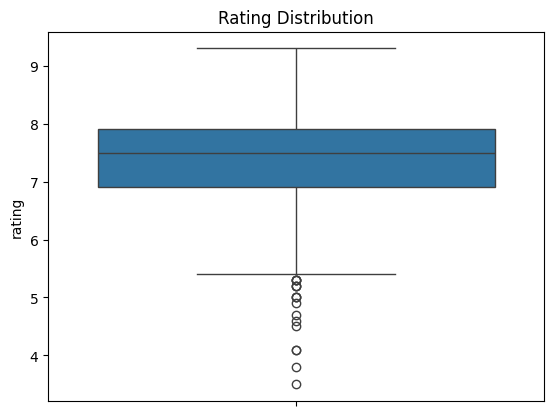

In [62]:

sns.boxplot(df['rating'])
plt.title("Rating Distribution")
plt.show()


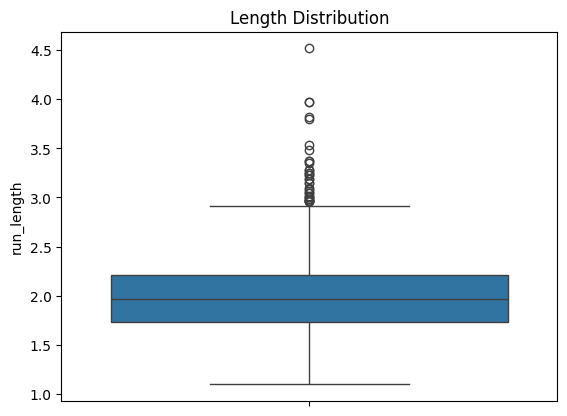

In [64]:
sns.boxplot(df['run_length'])
plt.title("Length Distribution")
plt.show()

In [70]:
'''
# 1. Combine all genres into a single list
all_genre = df['genres'].sum()  # This flattens the genres column into a list

# 2. Create a dictionary to count genre occurrences
genre_counts = {}
for genre in all_genre:
  if genre in genre_counts:
    genre_counts[genre] += 1  # Increment count if genre already exists
  else:
    genre_counts[genre] = 1  # Add genre with count 1 if new

# 3. Extract genre names and counts as separate lists
genre_names = list(genre_counts.keys())
genre_values = list(genre_counts.values())

# Rest of the code remains the same (using matplotlib and seaborn):

plt.figure(figsize=(15,5))
sns.barplot(x = genre_names, y = genre_values, palette = 'rocket')
plt.xticks(rotation = 45)
plt.title('Genres Count')
plt.show()
'''

"\n# 1. Combine all genres into a single list\nall_genre = df['genres'].sum()  # This flattens the genres column into a list\n\n# 2. Create a dictionary to count genre occurrences\ngenre_counts = {}\nfor genre in all_genre:\n  if genre in genre_counts:\n    genre_counts[genre] += 1  # Increment count if genre already exists\n  else:\n    genre_counts[genre] = 1  # Add genre with count 1 if new\n\n# 3. Extract genre names and counts as separate lists\ngenre_names = list(genre_counts.keys())\ngenre_values = list(genre_counts.values())\n\n# Rest of the code remains the same (using matplotlib and seaborn):\n\nplt.figure(figsize=(15,5))\nsns.barplot(x = genre_names, y = genre_values, palette = 'rocket')\nplt.xticks(rotation = 45)\nplt.title('Genres Count')\nplt.show()\n"

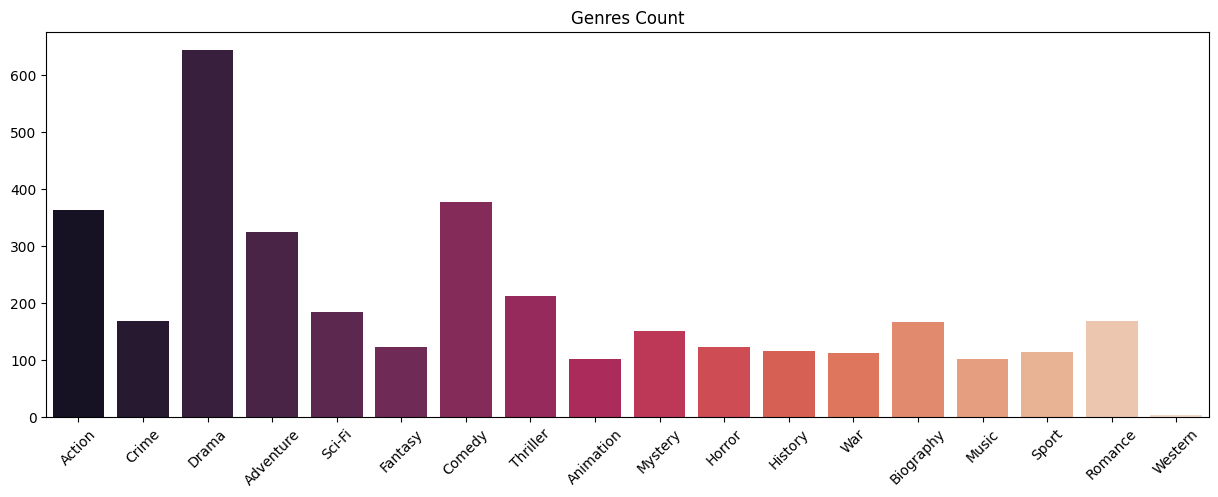

In [69]:

all_genre = sum(df['genres'],[])
all_genre = nltk.FreqDist(all_genre)
plt.figure(figsize=(15,5))
sns.barplot(x = list(all_genre.keys()), y = list(all_genre.values()),palette = 'rocket')
plt.xticks(rotation = 45)
plt.title('Genres Count')
plt.show()


In [76]:

#cleaning the text data
def clean_text(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()

    # removing stop-words
    STOPWORDS = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in STOPWORDS]

    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = PorterStemmer()
        sentence.append(lemmatizer.stem(word))

    return ' '.join(sentence)


In [72]:
df.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews,review
0,The Dark Knight,2008,PG-13,2.533333,"[Action, Crime, Drama]",18 July 2008 (USA),9.0,2224522,6836,Best movie ever. Heath ledger's work is phenom...
1,Inception,2010,PG-13,2.466667,"[Action, Adventure, Sci-Fi]",16 July 2010 (USA),8.8,1981675,3820,"My 3rd time watching this movie! Yet, it still..."
2,The Matrix,1999,R,2.266667,"[Action, Sci-Fi]",31 March 1999 (USA),8.7,1619761,4281,I have an interesting history and relationship...
3,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,2.966667,"[Action, Adventure, Drama]",19 December 2001 (USA),8.8,1609165,5365,Simply incredible. Never before have I seen a ...
4,The Dark Knight Rises,2012,PG-13,2.733333,"[Action, Adventure]",20 July 2012 (USA),8.4,1470329,2979,"After eight years in seclusion, Batman resurfa..."
